# 1. Install Dependencies and Setup

In [178]:
import tensorflow as tf
import os
import cv2

In [179]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [180]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

I'm sure taht this dataset is clear and not necessary to detect dodgy images, but it's standard practice if I use random pictures from web cause my Keras model works with 'jpeg','jpg', 'bmp', 'png' types of images.

In [181]:
image_path = os.path.join('data','fire_images','fire.1.png')
cv2.imread(image_path)

array([[[208, 209, 205],
        [207, 208, 204],
        [206, 207, 203],
        ...,
        [151, 166, 169],
        [152, 167, 170],
        [152, 167, 170]],

       [[208, 209, 205],
        [208, 209, 205],
        [208, 209, 205],
        ...,
        [150, 165, 168],
        [150, 165, 168],
        [150, 165, 168]],

       [[209, 210, 206],
        [209, 210, 206],
        [209, 210, 206],
        ...,
        [149, 163, 169],
        [149, 163, 169],
        [149, 163, 169]],

       ...,

       [[ 42,  55,  63],
        [ 34,  46,  56],
        [ 29,  43,  55],
        ...,
        [ 45,  85, 103],
        [ 41,  73,  92],
        [ 37,  64,  84]],

       [[ 43,  52,  61],
        [ 45,  55,  65],
        [ 35,  47,  59],
        ...,
        [ 18,  54,  70],
        [ 20,  48,  65],
        [ 21,  45,  63]],

       [[ 45,  52,  61],
        [ 49,  55,  66],
        [ 20,  28,  41],
        ...,
        [ 35,  56,  71],
        [ 40,  53,  69],
        [ 46,  54,  71]]

In [182]:
import imghdr

In [183]:
data_dir = 'data' 

In [184]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [186]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

NotADirectoryError: [Errno 20] Not a directory: 'data/.DS_Store'

# 3. Load Data

In [187]:
import numpy as np
from matplotlib import pyplot as plt

In [188]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 977 files belonging to 2 classes.


In [189]:
data_iterator = data.as_numpy_iterator()

In [190]:
batch = data_iterator.next()

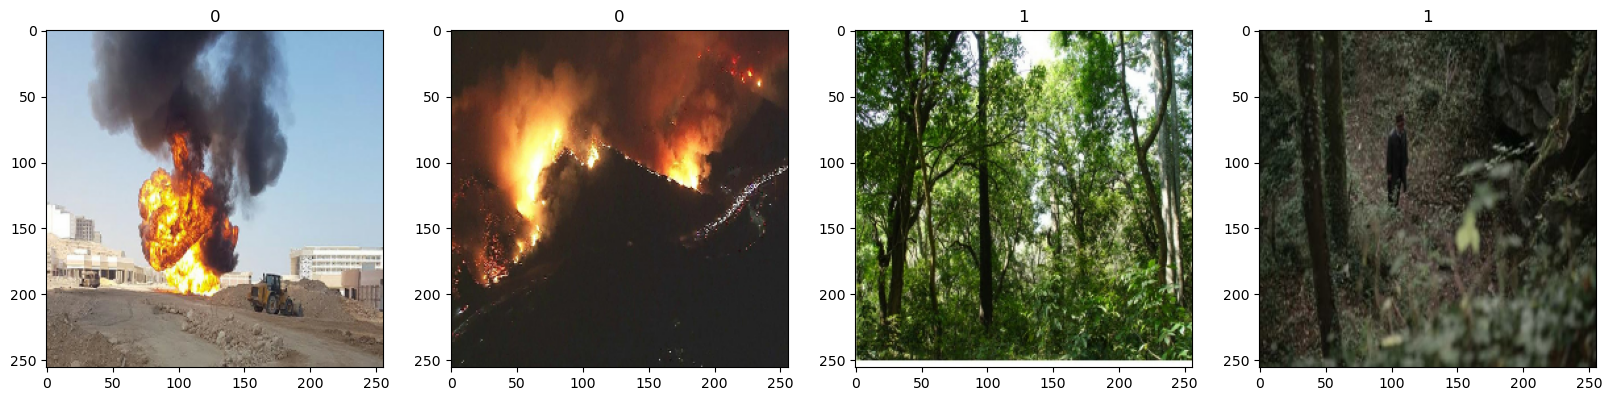

In [191]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [192]:
data = data.map(lambda x,y: (x/255, y))

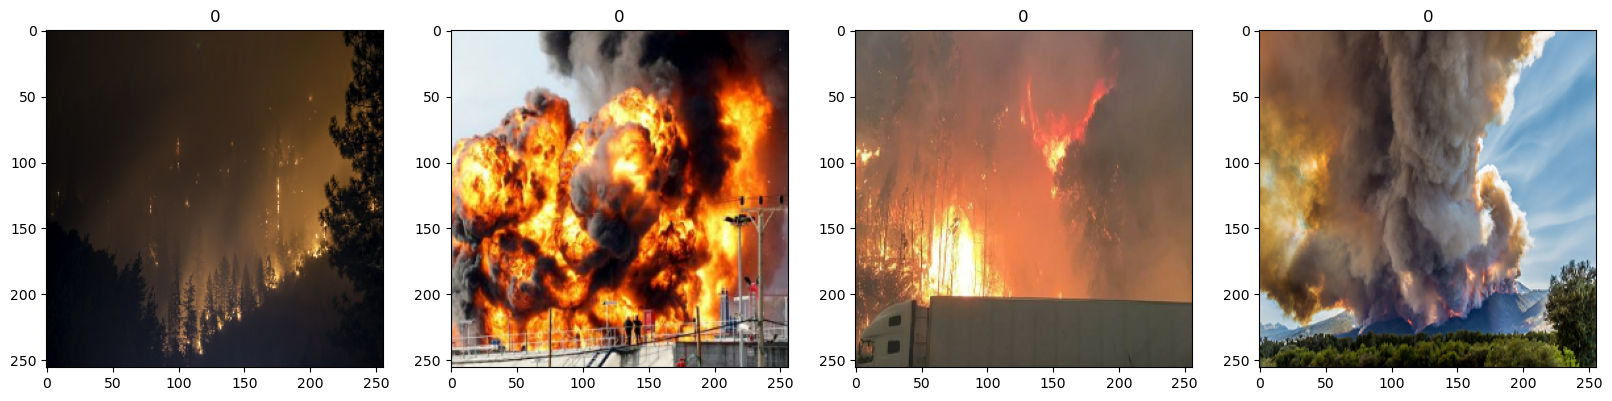

In [193]:
batch = data.as_numpy_iterator().next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

# 5. Split Data

In [194]:
print('Total number of batches: {}'.format(len(data)))

Total number of batches: 31


In [195]:
train_size = int(len(data)*.7) + 1
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [196]:
print('train set: {} batches'.format(train_size))
print('val set: {} batches'.format(val_size))
print('test set: {} batches'.format(test_size))

train set: 22 batches
val set: 6 batches
test set: 3 batches


In [197]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [198]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [199]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [200]:
model = Sequential()

In [201]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [202]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [203]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

# 7. Train

In [204]:
logdir='train_logs'

In [205]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [206]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
22/22 [==============================] - 13s 525ms/step - loss: 0.4854 - accuracy: 0.7940 - val_loss: 0.2613 - val_accuracy: 0.8802
Epoch 2/20
22/22 [==============================] - 13s 536ms/step - loss: 0.2450 - accuracy: 0.9105 - val_loss: 0.1662 - val_accuracy: 0.9271
Epoch 3/20
22/22 [==============================] - 13s 526ms/step - loss: 0.1681 - accuracy: 0.9290 - val_loss: 0.1310 - val_accuracy: 0.9635
Epoch 4/20
22/22 [==============================] - 13s 524ms/step - loss: 0.1116 - accuracy: 0.9545 - val_loss: 0.1185 - val_accuracy: 0.9531
Epoch 5/20
22/22 [==============================] - 13s 535ms/step - loss: 0.1319 - accuracy: 0.9503 - val_loss: 0.1819 - val_accuracy: 0.9219
Epoch 6/20
22/22 [==============================] - 13s 528ms/step - loss: 0.0934 - accuracy: 0.9716 - val_loss: 0.0943 - val_accuracy: 0.9583
Epoch 7/20
22/22 [==============================] - 13s 524ms/step - loss: 0.0740 - accuracy: 0.9659 - val_loss: 0.1831 - val_accuracy: 0.9271

# 8. Plot Performance

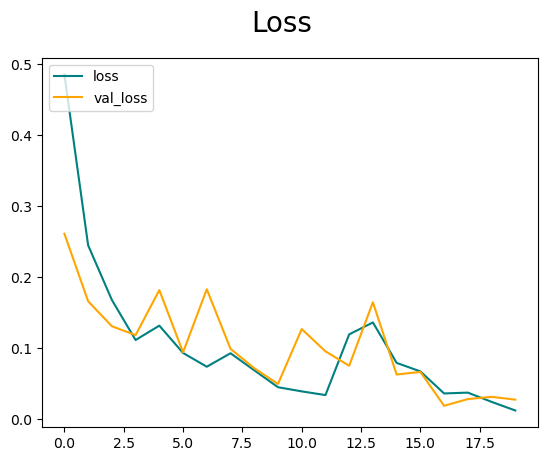

In [207]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

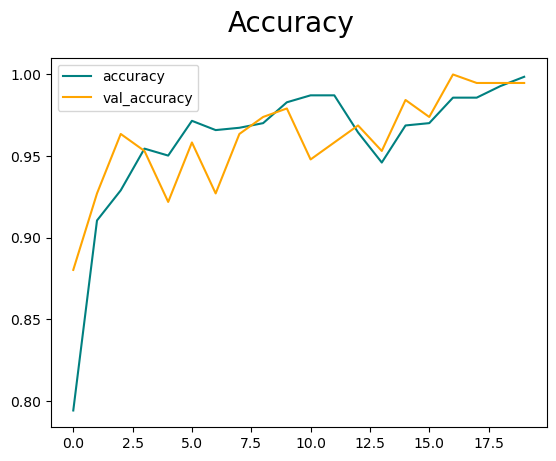

In [208]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [209]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [210]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [211]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 65ms/step


In [212]:
print('precision: {}'.format(pre.result()))
print('recall: {}'.format(re.result()))
print('accuracy: {}'.format(acc.result()))

precision: 0.9411764740943909
recall: 1.0
accuracy: 0.9876543283462524


# 10. Test

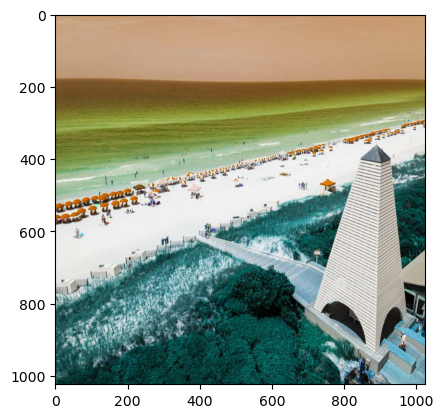

In [257]:
img = cv2.imread('prediction/test1/nonfire2.jpeg')
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.show()
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [258]:
yhat = model.predict(np.expand_dims(resize/255, 0))

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_1/dense_2/Relu' defined at (most recent call last):
    File "/Users/aweeu/anaconda3/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/aweeu/anaconda3/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/aweeu/anaconda3/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/Users/aweeu/anaconda3/lib/python3.10/asyncio/base_events.py", line 1906, in _run_once
      handle._run()
    File "/Users/aweeu/anaconda3/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/ty/y3x46lx53jb4q5wrxljsfp5r0000gn/T/ipykernel_1174/2554322616.py", line 1, in <module>
      yhat = model.predict(np.expand_dims(resize/255, 0))
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 2554, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 2341, in predict_function
      return step_function(self, iterator)
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 2327, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 2315, in run_step
      outputs = model.predict_step(data)
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 2283, in predict_step
      return self(x, training=False)
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/keras/src/engine/sequential.py", line 404, in call
      return super().call(inputs, training=training, mask=mask)
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/keras/src/activations.py", line 321, in relu
      return backend.relu(
    File "/Users/aweeu/anaconda3/lib/python3.10/site-packages/keras/src/backend.py", line 5397, in relu
      x = tf.nn.relu(x)
Node: 'sequential_1/dense_2/Relu'
Matrix size-incompatible: In[0]: [1,254016], In[1]: [14400,256]
	 [[{{node sequential_1/dense_2/Relu}}]] [Op:__inference_predict_function_21445]

In [216]:
yhat

array([[0.99931747]], dtype=float32)

In [217]:
if yhat > 0.5: 
    print(f'Predicted class is FIRE')
else:
    print(f'Predicted class is NON-FIRE')

Predicted class is FIRE


# 11. Save the Model

In [218]:
from tensorflow.keras.models import load_model

In [219]:
model.save(os.path.join('models','fire_classifier.h5'))

/Users/aweeu/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [233]:
new_model = load_model('models/fire_classifier.h5')

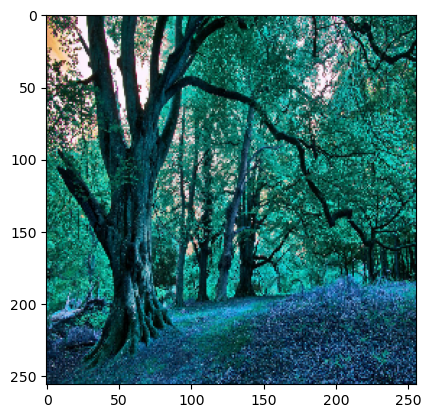

In [249]:
img = cv2.imread('prediction/test1/nonfire5.jpeg')
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.show()
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [250]:
subm = new_model.predict(np.expand_dims(resize/255, 0))
subm[0][0]

1/1 [==============================] - 0s 22ms/step


0.99999994

In [222]:
import pandas as pd
submission = pd.DataFrame({'file_name':[np.NaN],'submission_result':[np.NaN],'description':[np.NaN]})

In [254]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

submission.drop(submission.index, inplace=True)
data_dir = 'prediction'
target_folder = 'test1'


for image in os.listdir(os.path.join(data_dir, target_folder)):
    image_path = os.path.join(data_dir, target_folder, image)
    try:
        img = cv2.imread(image_path)
        tip = imghdr.what(image_path)
        if tip not in image_exts:
            os.remove(image_path)
    except Exception as e:
        print('Issue with image {}'.format(image_path))
        os.remove(image_path)
        
    
    file_name = [image]
    img = cv2.imread(image_path)
    resize = tf.image.resize(img, (256,256))
    predict = new_model.predict(np.expand_dims(resize/255, 0))[0][0]
    
    if predict > 0.5:
        new_row = {'file_name': file_name,
                   'submission_result':predict,
                   'description': 'FIRE'}
    else:
        new_row = {'file_name': file_name,
                   'submission_result':predict,
                   'description': 'NON-FIRE'}        
    
    submission = submission.append(new_row, ignore_index=True)
    

1/1 [==============================] - 0s 14ms/step


/var/folders/ty/y3x46lx53jb4q5wrxljsfp5r0000gn/T/ipykernel_1174/3012953142.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  submission = submission.append(new_row, ignore_index=True)
/var/folders/ty/y3x46lx53jb4q5wrxljsfp5r0000gn/T/ipykernel_1174/3012953142.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  submission = submission.append(new_row, ignore_index=True)
/var/folders/ty/y3x46lx53jb4q5wrxljsfp5r0000gn/T/ipykernel_1174/3012953142.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  submission = submission.append(new_row, ignore_index=True)
/var/folders/ty/y3x46lx53jb4q5wrxljsfp5r0000gn/T/ipykernel_1174/3012953142.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

1/1 [==============================] - 0s 13ms/step


/var/folders/ty/y3x46lx53jb4q5wrxljsfp5r0000gn/T/ipykernel_1174/3012953142.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  submission = submission.append(new_row, ignore_index=True)
/var/folders/ty/y3x46lx53jb4q5wrxljsfp5r0000gn/T/ipykernel_1174/3012953142.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  submission = submission.append(new_row, ignore_index=True)


In [255]:
submission

,file_name,submission_result,description
0,[fire2.jpeg],0.797468,FIRE
1,[nonfire1.jpeg],0.999998,FIRE
2,[non_fire.1.png],0.900839,FIRE
3,[nonfire2.jpeg],0.847671,FIRE
4,[fire1.jpeg],0.707686,FIRE
5,[nonfire3.jpeg],0.006400,NON-FIRE
6,[nonfire4.jpeg],0.798481,FIRE
7,[nonfire5.jpeg],1.000000,FIRE
